In [41]:
import sys
sys.path.append("../src")

import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from os.path import join

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, GlobalAvgPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

from icao_dataset import ICAODataset
from utils import plot, load

from global_config import FILE_DATASET, IMAGE_SIZE, RANDOM_SEED

%matplotlib inline

In [2]:
PATH_TO_ROOT = ".."

FILE_DATASET = join(PATH_TO_ROOT, FILE_DATASET)
FOLDER_MODELS = join(PATH_TO_ROOT, "models/landmarks/")

print(FILE_DATASET)
print(FOLDER_MODELS)

..\data/cropped_faces_eyes/dataset_dlib.pkl
..\models/landmarks/


In [3]:
TEST_SIZE = 0.1

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

# Data Loading 

In [5]:
dataset = pkl.load(open(FILE_DATASET, "rb"))
print(len(dataset.images))

5572


In [6]:
x = np.array(dataset.images)
mrks = dataset.mrks
y = np.array([mrk_file.right_eye.center().as_list() + mrk_file.left_eye.center().as_list() for mrk_file in mrks])

print(x.shape, x.dtype)
print(y.shape, y.dtype)
print(len(mrks))

(5572, 160, 160, 3) float32
(5572, 4) float64
5572


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=RANDOM_SEED)

print(x_train.shape, x_train.dtype)
print(x_test.shape, x_test.dtype)
print(y_train.shape, y_train.dtype)
print(y_test.shape, y_test.dtype)

(5014, 160, 160, 3) float32
(558, 160, 160, 3) float32
(5014, 4) float64
(558, 4) float64


In [10]:
model = Sequential([
    Conv2D(16, (3, 3), padding="same", activation="relu", input_shape=x_train.shape[1:]), # name="input"
    MaxPool2D(),
    Conv2D(32, (3, 3), padding="same", activation="relu"),
    MaxPool2D(),
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    MaxPool2D(),
    Conv2D(128, (3, 3), padding="same", activation="relu"),
    MaxPool2D(),
    GlobalAvgPool2D(),
    Dropout(rate=0.5),
    Dense(units=64, activation="relu"),
    Dropout(rate=0.5),
    Dense(units=64, activation="relu"),
    Dense(units=4, activation="sigmoid", name="output_eyes"),
])
model.summary()

model.compile(optimizer="adam", loss="mean_squared_error")

FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix="landmarks_")
list_callbacks = [
    ModelCheckpoint(FILE_MODEL, monitor="val_loss", mode="min", verbose=1, save_best_only=True), 
    EarlyStopping(monitor="val_loss", mode="min", patience=30, verbose=1, restore_best_weights=True)
]

hist = model.fit(
    x=x_train / 255,
    y=y_train / IMAGE_SIZE[0],
    validation_data=(x_test / 255, y_test / IMAGE_SIZE[0]),
    batch_size=32,
    epochs=100,
    callbacks=list_callbacks,
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 20, 20, 128)      

5014/5014 [==============================] - 7s 1ms/step - loss: 2.8688e-04 - val_loss: 2.9251e-04

Epoch 00031: val_loss improved from 0.00030 to 0.00029, saving model to ..\models/landmarks/landmarks_2022_06_04-15_18_46.h5
Epoch 32/100
5014/5014 [==============================] - 7s 1ms/step - loss: 2.8622e-04 - val_loss: 2.9151e-04

Epoch 00032: val_loss improved from 0.00029 to 0.00029, saving model to ..\models/landmarks/landmarks_2022_06_04-15_18_46.h5
Epoch 33/100
5014/5014 [==============================] - 7s 1ms/step - loss: 2.8726e-04 - val_loss: 2.9072e-04

Epoch 00033: val_loss improved from 0.00029 to 0.00029, saving model to ..\models/landmarks/landmarks_2022_06_04-15_18_46.h5
Epoch 34/100
5014/5014 [==============================] - 7s 1ms/step - loss: 2.8524e-04 - val_loss: 2.8926e-04

Epoch 00034: val_loss improved from 0.00029 to 0.00029, saving model to ..\models/landmarks/landmarks_2022_06_04-15_18_46.h5
Epoch 35/100
5014/5014 [==============================] - 7s 

5014/5014 [==============================] - 7s 1ms/step - loss: 2.2207e-04 - val_loss: 2.5545e-04

Epoch 00074: val_loss did not improve from 0.00024
Epoch 75/100
5014/5014 [==============================] - 7s 1ms/step - loss: 2.2169e-04 - val_loss: 2.4236e-04

Epoch 00075: val_loss did not improve from 0.00024
Epoch 76/100
5014/5014 [==============================] - 7s 1ms/step - loss: 2.1681e-04 - val_loss: 2.4172e-04

Epoch 00076: val_loss did not improve from 0.00024
Epoch 77/100
5014/5014 [==============================] - 7s 1ms/step - loss: 2.1521e-04 - val_loss: 2.4166e-04

Epoch 00077: val_loss did not improve from 0.00024
Epoch 78/100
5014/5014 [==============================] - 7s 1ms/step - loss: 2.1398e-04 - val_loss: 2.3308e-04

Epoch 00078: val_loss improved from 0.00024 to 0.00023, saving model to ..\models/landmarks/landmarks_2022_06_04-15_18_46.h5
Epoch 79/100
5014/5014 [==============================] - 7s 1ms/step - loss: 2.1273e-04 - val_loss: 2.3752e-04

Epoch 

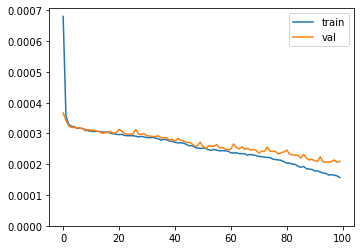

In [12]:
plot.keras_hist(hist.history)

In [14]:
y_pred = model.predict(x_test / 255)

In [15]:
y_pred

array([[0.42519692, 0.4449388 , 0.5840342 , 0.44299522],
       [0.4199348 , 0.48820087, 0.60437655, 0.48668477],
       [0.420547  , 0.47893998, 0.59783876, 0.47634095],
       ...,
       [0.4259341 , 0.44852328, 0.58162427, 0.4464519 ],
       [0.42588946, 0.46475297, 0.5743954 , 0.46032056],
       [0.4185085 , 0.43851495, 0.5783862 , 0.4354308 ]], dtype=float32)

In [17]:
y_test / IMAGE_SIZE[0]

array([[0.40625 , 0.4625  , 0.56875 , 0.459375],
       [0.428125, 0.509375, 0.609375, 0.509375],
       [0.4125  , 0.484375, 0.59375 , 0.484375],
       ...,
       [0.434375, 0.415625, 0.6     , 0.434375],
       [0.440625, 0.471875, 0.578125, 0.459375],
       [0.4375  , 0.453125, 0.6     , 0.44375 ]])

In [18]:
y_pred * IMAGE_SIZE[0]

array([[68.03151 , 71.19021 , 93.44547 , 70.879234],
       [67.18957 , 78.11214 , 96.70025 , 77.86956 ],
       [67.28752 , 76.630394, 95.654205, 76.214554],
       ...,
       [68.14946 , 71.763725, 93.05988 , 71.432304],
       [68.14231 , 74.36047 , 91.90327 , 73.65129 ],
       [66.96136 , 70.16239 , 92.541794, 69.66893 ]], dtype=float32)

In [20]:
y_test

array([[65. , 74. , 91. , 73.5],
       [68.5, 81.5, 97.5, 81.5],
       [66. , 77.5, 95. , 77.5],
       ...,
       [69.5, 66.5, 96. , 69.5],
       [70.5, 75.5, 92.5, 73.5],
       [70. , 72.5, 96. , 71. ]])

In [21]:
(y_pred * IMAGE_SIZE[0]).mean(axis=0)

array([67.92452 , 72.16027 , 93.094025, 71.78851 ], dtype=float32)

In [22]:
y_test.mean(axis=0)

array([68.23476703, 72.49193548, 92.77150538, 72.23655914])

[69.5 66.5 93.  68.5]
[66.1947   65.2036   92.889336 65.039406]


Text(0.5, 1.0, 'original image')

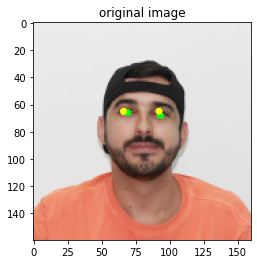

In [39]:
random_idx = np.random.choice(x_test.shape[0])
im = np.expand_dims(x_test[random_idx], axis=0)
y_true_eyes = y_test[random_idx]

y_pred_eyes = model.predict(im / 255)
y_pred_eyes = (y_pred_eyes * im.shape[1]).flatten()

print(y_true_eyes, y_pred_eyes, sep='\n')

im = im.squeeze()[:, :, ::-1].astype(np.uint8)
true_r = tuple(y_true_eyes[:2].astype(np.int))
true_l = tuple(y_true_eyes[2:].astype(np.int))
pred_r = tuple(y_pred_eyes[:2].astype(np.int))
pred_l = tuple(y_pred_eyes[2:].astype(np.int))
cv2.circle(im, true_r, radius=1, color=(0, 255, 0), thickness=2)
cv2.circle(im, true_l, radius=1, color=(0, 255, 0), thickness=2)
cv2.circle(im, pred_r, radius=1, color=(255, 255, 0), thickness=2)
cv2.circle(im, pred_l, radius=1, color=(255, 255, 0), thickness=2)

plt.figure(figsize=(10, 4))
plt.imshow(im)
plt.title('original image')

In [40]:
FILE_MODEL

'..\\models/landmarks/landmarks_2022_06_04-15_18_46.h5'

In [48]:
list_files = [PATH_TO_ROOT + '/data/cropped_faces_eyes/images/afwDB_0.png']

im = load.images_from_list_files(list_files, output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)

model.predict(im / 255)

1 of 1


array([[0.44194162, 0.44742066, 0.5984565 , 0.44950888]], dtype=float32)

In [49]:
list_files = [PATH_TO_ROOT + '/data/cropped_faces/images/afwDB_0.png']

im = load.images_from_list_files(list_files, output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)

model.predict(im / 255)

1 of 1


array([[0.44211754, 0.4474577 , 0.59861106, 0.4495935 ]], dtype=float32)